# **MP4_report_59**

##組員與分工

組員: 林群佑, 刁一平

|      工作項目      |      分工     |
|:------------------:|:-------------:|
| Part I report (1)(2) |     林群佑    |
|      Part I report (3)(4)(5)     |     刁一平    |
|      功能實作與除錯      |  林群佑   刁一平    |
|      實作 report     |     刁一平    |

## Part I. Understanding NachOS file system

### (1) How does the NachOS FS manage and find free block space? Where is this information stored on the raw disk (which sector)?

In [ ]:
FileSystem::FileSystem(bool format)
{
    DEBUG(dbgFile, "Initializing the file system.");
    if (format)
    {
        PersistentBitmap *freeMap = new PersistentBitmap(NumSectors);
        Directory *directory = new Directory(NumDirEntries);
        FileHeader *mapHdr = new FileHeader;
        FileHeader *dirHdr = new FileHeader;

        DEBUG(dbgFile, "Formatting the file system.");

        // First, allocate space for FileHeaders for the directory and bitmap
        // (make sure no one else grabs these!)
        freeMap->Mark(FreeMapSector);
        freeMap->Mark(DirectorySector);

        // Second, allocate space for the data blocks containing the contents
        // of the directory and bitmap files.  There better be enough space!

        ASSERT(mapHdr->Allocate(freeMap, FreeMapFileSize));
        ASSERT(dirHdr->Allocate(freeMap, DirectoryFileSize));

        // Flush the bitmap and directory FileHeaders back to disk
        // We need to do this before we can "Open" the file, since open
        // reads the file header off of disk (and currently the disk has garbage
        // on it!).

        DEBUG(dbgFile, "Writing headers back to disk.");
        mapHdr->WriteBack(FreeMapSector);
        dirHdr->WriteBack(DirectorySector);

        // OK to open the bitmap and directory files now
        // The file system operations assume these two files are left open
        // while Nachos is running.

        freeMapFile = new OpenFile(FreeMapSector);
        directoryFile = new OpenFile(DirectorySector);

        // Once we have the files "open", we can write the initial version
        // of each file back to disk.  The directory at this point is completely
        // empty; but the bitmap has been changed to reflect the fact that
        // sectors on the disk have been allocated for the file headers and
        // to hold the file data for the directory and bitmap.

        DEBUG(dbgFile, "Writing bitmap and directory back to disk.");
        freeMap->WriteBack(freeMapFile); // flush changes to disk
        directory->WriteBack(directoryFile);

        if (debug->IsEnabled('f'))
        {
            freeMap->Print();
            directory->Print();
        }
        delete freeMap;
        delete directory;
        delete mapHdr;
        delete dirHdr;
    }
    else
    {
        // if we are not formatting the disk, just open the files representing
        // the bitmap and directory; these are left open while Nachos is running
        freeMapFile = new OpenFile(FreeMapSector);
        directoryFile = new OpenFile(DirectorySector);
    }
}

我們可以進到 filesys.cc 觀察 FileSystem::FileSystem 函式一窺如何格式化硬碟，進而了解 NachOS 管理空閒區塊方式

首先 NachOS 使用 bitmap 來管理磁碟的空閒區塊，而 bitmap 會在檔案系統掛載時被載入記憶體，以便快速查找空閒區塊

In [ ]:
Bitmap::Bitmap(int numItems)
{
    int i;

    ASSERT(numItems > 0);

    numBits = numItems;
    numWords = divRoundUp(numBits, BitsInWord);
    map = new unsigned int[numWords];
    for (i = 0; i < numWords; i++)
    {
        map[i] = 0; // initialize map to keep Purify happy
    }
    for (i = 0; i < numBits; i++)
    {
        Clear(i);
    }
}

進到 bitmap.cc 可以看到， bitmap 初始皆設為 0 故可以得出以下結論

* 0 表示該區塊是空的，可以分配
* 1 表示該區塊已被使用

In [ ]:
int Bitmap::FindAndSet()
{
    for (int i = 0; i < numBits; i++)
    {
        if (!Test(i))
        {
            Mark(i);
            return i;
        }
    }
    return -1;
}

當需要新的區塊時，系統掃描 bitmap ，找到第一個為 0 的 bit ，將其設為 1

In [ ]:
#define FreeMapSector 0
#define DirectorySector 1

由定義我們可知：
* Sector 0 為 FreeMap 的 file header 存放的地方
* Sector 1 為 Directory 的 file header 存放的地方

而理論上來說，接下來就會分配空間給 FreeMap 所以， FreeMap 應該是從 Sector 2 開始儲存

### (2) What is the maximum disk size that can be handled by the current implementation? Explain why.


In [ ]:
const int SectorSize = 128;		// number of bytes per disk sector
const int SectorsPerTrack  = 32;	// number of sectors per disk track
const int NumTracks = 32;		// number of tracks per disk
const int NumSectors = (SectorsPerTrack * NumTracks); // total # of sectors per disk

在 disk.h 裡，這段程式碼定義了 NachOS 模擬磁碟的基本參數，用來描述磁碟的結構與容量

1. SectorSize : 每個 sector 的大小是 128 Bytes ，是磁碟的最小存取單位
2. SectorsPerTrack : 每條 track 包含 32 個 sectors
3. NumTracks : 整個磁碟由 32 個 tracks 組成
4. NumSectors : 總區塊數 = 每條磁軌的區塊數 × 總磁軌數。
在這裡：
NumSectors = 32 × 32 = 1024
表示 disk 總共有 1024 個 sectors ，因此 disk 的總容量為：

  NumSectors × SectorSize = 1024 × 128 Bytes = 131072 Bytes = 128 KB

### (3) How does the NachOS FS manage the directory data structure? Where is this information stored on the raw disk (which sector)?

NachOS FS 把 directory 當成一個 file 來管理，有 header 和 dataSectors

Data 是 Directory ，用來記錄檔案名稱和檔案 fileHeader 位置


FileSystem 的建構式負責初始化檔案系統。若需要格式化，會建立一個包含 10 個 DirectoryEntry 的 Directory，並配置對應的 FileHeader

Directory 大小為 200 bytes，需要使用兩個sector來儲存。dirHdr 被寫入的第 1 號sector，而 Directory 的資料則分配到第 3 和 4 號sector，最後開啟 directoryFile，將變更寫入檔案。如果不需格式化，則直接從第 1 號sector開啟 directoryFile

FileSystem 提供了幾個主要的方法來管理 Directory：

Create ：
用來創建檔案。它會先檢查 Directory 中是否已有同名檔案，若有則創建失敗。接著，會從 freeMap 找到可用的sector，分配給檔案的 fileHeader 和資料。如果檔案超出容量限制（最多 10 個檔案）或sector不足，創建失敗。最後，將更新的 fileHeader、Directory 和 freeMap 寫回硬碟

Open ：
用來開啟檔案，從 Directory 中尋找檔案的 fileHeader 對應的sector

若找到，會返回開啟的檔案；若找不到，則返回 NULL

Remove ：
用來刪除檔案。它會從 Directory 中確認檔案是否存在，然後釋放檔案的 fileHeader 和資料塊，並將它們歸還到 freeMap。最後，將更新的 Directory 和 freeMap 寫回硬碟

List ：
從 Directory 中讀取所有已使用的檔案條目，並列出這些檔案的名稱。

Print ：
負責印出檔案系統的詳細資訊，包括 freeMap 的狀態、Directory 的內容，以及每個檔案的 fileHeader 和檔案內容。

###(4) Explain what information is stored in an inode, and use a figure to illustrate the disk allocation scheme of current implementation.

In [ ]:
	int numBytes;				// Number of bytes in the file
	int numSectors;				// Number of data sectors in the file
	int dataSectors[NumDirect]; // Disk sector numbers for each data

透過 FileHeader class 中的private memeber可以看到 inode 所儲存的相關資訊

其中numBytes 為檔案的大小，numSectors為檔案使用sector的數目，
dataSectors[NumDirect]為每個dataBlock在哪個sector

由此可知 Nachos 使用的是 **direct index** scheme

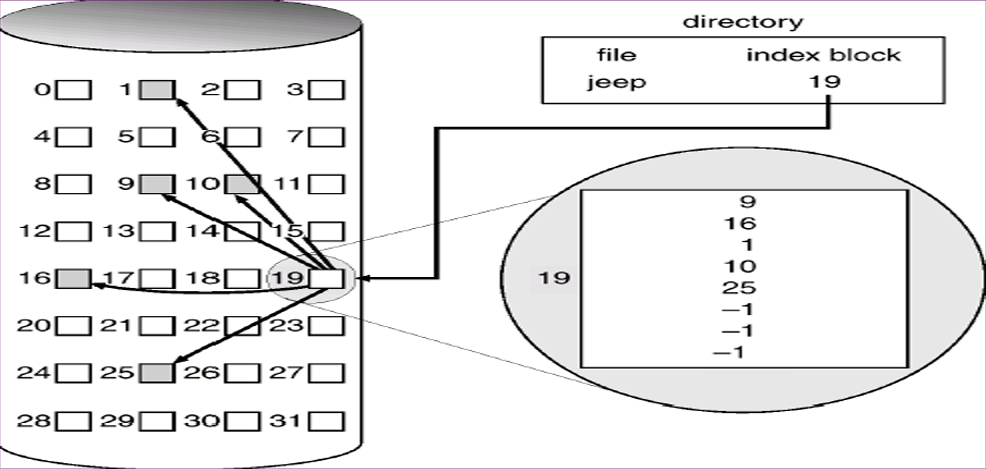

Figure of direct index

###(5) Why a file is limited to 4KB in the current implementation?

In [ ]:
bool FileHeader::Allocate(PersistentBitmap *freeMap, int fileSize)
{
  :
	for (int i = 0; i < numSectors; i++)
	{
		dataSectors[i] = freeMap->FindAndSet();
		// since we checked that there was enough free space,
		// we expect this to succeed
		ASSERT(dataSectors[i] >= 0);
	}

由Allocate得知 fileHeader只有一層，一個fileHeader能用的空間就只有32個sector的大小

In [ ]:
#define NumDirect 	((SectorSize - 2 * sizeof(int)) / sizeof(int))
#define MaxFileSize 	(NumDirect * SectorSize)

FileHeader的大小為128 bytes


扣除numBytes和numSectors後，剩餘120 bytes用於存放長度為30的dataSectors

NumDirect 為 (128 - 2*4) / 4 = 30，

因此MaxFileSize = 30*128，為 3.75KB



##Implement part

###Part II. Modify the file system code to support file I/O system calls and larger file size

###Implement five system calls

首先與MP1大致相同，user呼叫system call後，進入syscall.h，接著程式執行後，會進到exception.cc對應的case，
，再呼叫ksyscall.h 中對應的function，最後呼叫fileSystem下對應的function

####kyscall.h

In [ ]:
int sysCreate(char *name, int size){
	return kernel->fileSystem->Create0(name, size);
}
OpenFileId sysOpen(char *name){
	return kernel->fileSystem->Open0(name);
}
int sysRead(char *buf, int size, OpenFileId id){
	return kernel->fileSystem->Read0(buf, size, id);
}
int sysWrite(char *buf, int size, OpenFileId id){
	return kernel->fileSystem->Write0(buf, size, id);
}
int sysClose(OpenFileId id){
	return kernel->fileSystem->Close0(id);
}

在ksyscall.h加上Systemcall介面

####exception.cc

In [ ]:
		case SC_Create:
			val = kernel->machine->ReadRegister(4);
			{
				char *filename = &(kernel->machine->mainMemory[val]);
				//cout << filename << endl;
				int size = kernel->machine->ReadRegister(5);
				status = sysCreate(filename, size);
				kernel->machine->WriteRegister(2, (int)status);
			}
			kernel->machine->WriteRegister(PrevPCReg, kernel->machine->ReadRegister(PCReg));
			kernel->machine->WriteRegister(PCReg, kernel->machine->ReadRegister(PCReg) + 4);
			kernel->machine->WriteRegister(NextPCReg, kernel->machine->ReadRegister(PCReg) + 4);
			return;
			ASSERTNOTREACHED();
			break;
		case SC_Close:
			val = kernel->machine->ReadRegister(4);
			{
				char *filename = &(kernel->machine->mainMemory[val]);
				//cout << filename << endl;
				status = sysClose(val);
				kernel->machine->WriteRegister(2, (int)status);
			}
			kernel->machine->WriteRegister(PrevPCReg, kernel->machine->ReadRegister(PCReg));
			kernel->machine->WriteRegister(PCReg, kernel->machine->ReadRegister(PCReg) + 4);
			kernel->machine->WriteRegister(NextPCReg, kernel->machine->ReadRegister(PCReg) + 4);
			return;
			ASSERTNOTREACHED();
			break;
      #剩下省略

比照MP1，加上Systemcall的定義，除了SC_Create多帶了一個檔案大小的參數之外，其他方法都與MP1的實作一模一樣

####filesys

In [ ]:
	int Close0(OpenFileId id);
	int Write0(char *buf, int size, OpenFileId id);
	int Read0(char *buf, int size, OpenFileId id);
	OpenFileId Open0(char *name);
	int Create0(char *name, int size);
  OpenFile* filetable[20];

與MP1大致相同，只是多了CreateFile()，且新增
filetable 來儲存開啟的檔案

In [ ]:
int FileSystem::Close0(OpenFileId id){
    if(id<0 || id>=20) return -1;
    if(filetable[id] == NULL) return -1;
    delete filetable[id];
    filetable[id] = NULL;
    return 1;
}
int FileSystem::Write0(char *buf, int size, OpenFileId id){
    if(id<0 || id>=20 || size<0) return -1;
    if(filetable[id] == NULL) return -1;
    return filetable[id]->Write(buf, size);
}
int FileSystem::Read0(char *buf, int size, OpenFileId id){
    if(id<0 || id>=20 || size<0) return -1;
    if(filetable[id] == NULL) return -1;
    return filetable[id]->Read(buf, size);
}
OpenFileId FileSystem::Open0(char *name){
    OpenFile *file = Open(name);
    if(file == NULL) return -1;
    for(int i=0 ; i<20 ; ++i){
        if(filetable[i] == NULL){
            filetable[i] = file;
            return i;
        }
    }
    delete file;
    return -1;
}
int FileSystem::Create0(char *name, int size){
    return Create(name, size);
}

###Enhance the FS to let it support up to 32KB file size

原版本僅支援單一 FileHeader，檔案大小被限制為最多 MaxFileSize。
無法處理需要跨多個index block的檔案分配需求  
所以我將原本的 index scheme 轉為 linked index scheme，使檔案的長度不再受限制。為此，我在 filehdr.h 中新增了兩個 private 變數：nextHeader 和 nextHeaderSector，用來儲存下一個 index block 的相關資訊。其中， nextHeader 放在變數宣告的最前面，而這個是不必寫回 disk 的資訊， WriteBack() 時會加上 sizeof(FileHeader*) 這樣便可跳過。具體的實作細節會在後續進一步說明。此外， NumDirect 也需要更新，扣除 nextHeaderSector ( 用來儲存下一個 sector 的位置 ) 所佔的空間，以確保需要寫回硬碟的資料大小與 sector 大小完全匹配。

####filehdr

In [ ]:
	FileHeader *nextfileheader;
	int nextfilesector;

In [ ]:
#define NumDirect ((SectorSize - 3 * sizeof(int)) / sizeof(int))

In [ ]:
FileHeader::FileHeader()
{
	numBytes = -1;
	numSectors = -1;
	//MP4
	nextfileheader = NULL;
	nextfilesector = -1;
	//MP4 end
	memset(dataSectors, -1, sizeof(dataSectors));
}

In [ ]:
FileHeader::~FileHeader()
{
	// nothing to do now
	//MP4
	if(nextfileheader != NULL) delete nextfileheader;
	//MP4 end
}

在constructor和destructor中初始化和刪除nextfileheader, nextfilesector

In [ ]:
bool FileHeader::Allocate(PersistentBitmap *freeMap, int fileSize)
{
	//MP4
	DEBUG('f',"fileheader allocate");
	numBytes = fileSize<MaxFileSize? fileSize:MaxFileSize;
	fileSize -= numBytes;
	numSectors = divRoundUp(numBytes, SectorSize);
	//MP4 end
	if (freeMap->NumClear() < numSectors)
		return FALSE; // not enough space

	for (int i = 0; i < numSectors; i++)
	{
		dataSectors[i] = freeMap->FindAndSet();
		// since we checked that there was enough free space,
		// we expect this to succeed
		ASSERT(dataSectors[i] >= 0);
	}
	//MP4
	if(fileSize <= 0) return TRUE;
	nextfilesector = freeMap->FindAndSet();
	if(nextfilesector == -1) return FALSE;
	if(nextfileheader != NULL) delete nextfileheader;
	nextfileheader = new FileHeader;
	return nextfileheader->Allocate(freeMap, fileSize);
	//MP4 end
}


在Allocate使用遞迴呼叫 nextfileheader->Allocate，分配剩餘的 fileSize，直到完全分配完成

In [ ]:
void FileHeader::Deallocate(PersistentBitmap *freeMap)
{
	for (int i = 0; i < numSectors; i++)
	{
		ASSERT(freeMap->Test((int)dataSectors[i])); // ought to be marked!
		freeMap->Clear((int)dataSectors[i]);
	}
	//MP4
	if(nextfilesector == -1) return;
	ASSERT(nextfileheader != NULL);
	nextfileheader->Deallocate(freeMap);
	//MP4 end
}


Deallocate()則是會繼續往下一個file header 遞迴呼叫
Deallocate()

In [ ]:
void FileHeader::FetchFrom(int sector)
{
	//MP4
	kernel->synchDisk->ReadSector(sector, (char *)this + sizeof(FileHeader*));
	//MP4 end
	/*
		MP4 Hint:
		After you add some in-core informations, you will need to rebuild the header's structure
	*/
	//MP4
	if(nextfilesector == -1) return;
	if(nextfileheader != NULL)
		delete nextfileheader;
	nextfileheader = new FileHeader;
	nextfileheader->FetchFrom(nextfilesector);
	//MP4 end
}

在 FetchFrom()中，若存在下一個 FileHeader，則會遞迴呼叫下一個 FileHeader 的 FetchFrom()

In [ ]:
void FileHeader::WriteBack(int sector)
{
	//MP4
	DEBUG('f',"FileHeader::WriteBack at Sector: "<<sector<<" NextSector: "<<nextfilesector);
	kernel->synchDisk->WriteSector(sector, (((char *)this) + sizeof(FileHeader*)));

	/*
		MP4 Hint:
		After you add some in-core informations, you may not want to write all fields into disk.
		Use this instead:
		char buf[SectorSize];
		memcpy(buf + offset, &dataToBeWritten, sizeof(dataToBeWritten));
		...
	*/
	DEBUG(dbgFile, "Writing next headers back to disk.");
	if(nextfileheader == NULL || nextfilesector == -1) return;
	nextfileheader->WriteBack(nextfilesector);
	//MP4 end
}

在 WriteBack()時，會將 this 加上 sizeof(FileHeader*)用來跳過不需存回disk的nextHeader

In [ ]:
int FileHeader::ByteToSector(int offset)
{
	//MP4
	int index = offset/SectorSize;
	if(index<NumDirect)
		return dataSectors[index];
	ASSERT(nextfileheader != NULL);
	return nextfileheader->ByteToSector(offset - MaxFileSize);
	//MP4 end
}

在ByteToSector()中， 如果offset超過這個block儲存的size，就會遞迴的向下尋找，然後將offset減掉MaxFileSize。

In [ ]:
int FileHeader::FileLength()
{
	//MP4
	if(nextfileheader!=NULL)
		return numBytes+nextfileheader->FileLength();
	return numBytes;
	//MP4 end
}

FileLength()則是遞迴後加上numBytes後回傳

###Part III. Modify the file system code to support the subdirectory

In [ ]:
class DirectoryEntry
{
public:
    bool isDir;
}

首先，在DirectoryEntry 新增一個 variable  isDir，用來判斷此
entry 的資料是directory 還是file

In [ ]:
bool Add(char *name, int newSector, bool isDir); // Add a file name into the directory
void RecursiveList(int layer);
int GetDirSector(char *name);

In [ ]:
bool Directory::Add(char *name, int newSector, bool isDir)
{//MP4 end
    if (FindIndex(name) != -1)
        return FALSE;

    for (int i = 0; i < tableSize; i++)
        if (!table[i].inUse)
        {
            table[i].inUse = TRUE;
            strncpy(table[i].name, name, FileNameMaxLen);
            table[i].sector = newSector;
            //MP4
            table[i].isDir = isDir;
            //MP4 end
            return TRUE;
        }
    return FALSE; // no space.  Fix when we have extensible files.
}

在 Directory 中，將原本的 Add() 方法新增一個 isDir 參數，用於標記新增項目是否為目錄，並在找到目錄項目後設定對應的 isDir 資料。此外，新增 RecursiveList() 方法以實現遞迴列出目錄內容的功能（類似 -lr）。同時，實作 GetDirSector() 方法，接收相對路徑並返回對應檔案或目錄的sector編號，以支援更靈活的路徑操作。

In [ ]:
void Directory::List()
{
    for (int i = 0; i < tableSize; i++)
        if (table[i].inUse)//MP4
            printf("%s\n", table[i].name);
        //MP4 end
}

在 List() 中，修改輸出格式

In [ ]:
void Directory::RecursiveList(int layer){
    Directory *sub = new Directory(NumDirEntries);
    for(int i=0;i<tableSize;++i){
        if(table[i].inUse){
            for(int j=0;j<layer;++j) printf("    ");
            printf("[%c] %s\n",(table[i].isDir? 'D':'F'), table[i].name);
            if(table[i].isDir){
                OpenFile *file = new OpenFile(table[i].sector);
                sub->FetchFrom(file);
                sub->RecursiveList(layer+1);
                delete file;
            }
        }
    }
}

在 RecursiveList() 中，根據當前層級添加對應數量的縮排，然後輸出每個項目。若項目為目錄，則遞迴呼叫 RecursiveList()，並將layer加 1，以處理其子目錄的內容

In [ ]:
class FileSystem
{
public:
  bool CreateDirectory(char *name);
	void RecursiveList(char *name);
private:
	void SplitPath(char *path, char *dirName, char *fileName);
}

在FileSystem下新增三個function,其功用會在下方做說明

In [ ]:
void FileSystem::SplitPath(char *path, char *dirName, char *fileName){
    int len = strlen(path), i;
    for(i=len-1;i>=0;i--){
        if(path[i] == '/') break;
    }
    strncpy(dirName, path, i);
    strncpy(fileName, path+i+1, len-i-1);
    dirName[i] = fileName[len-i-1] = '\0';
    if(i==0) dirName[0] = '/', dirName[1]='\0';
}

SplitPath() 的主要功能是處理字串，將路徑分割為兩部分，並將結果分別存入 dirName 和 fileName。

In [ ]:
bool FileSystem::Create(char *name, int initialSize)
{
    //MP4
    Directory *directory, *root;
    OpenFile *file;
    int dirSector;
    char dirName[256], fileName[10];
    SplitPath(name, dirName, fileName);
    //MP4 end
    PersistentBitmap *freeMap;
    FileHeader *hdr;
    int sector;
    bool success;

    DEBUG(dbgFile, "Creating file " << name << " size " << initialSize);
    //MP4
    root = new Directory(NumDirEntries);
    directory = new Directory(NumDirEntries);
    DEBUG('f',"FetchFrom Dir Name: "<<dirName);
    root->FetchFrom(directoryFile);
    DEBUG('f',"GetDirSector Dir Name: "<<dirName);
    dirSector = root->GetDirSector(dirName);
    file = new OpenFile(dirSector);
    DEBUG('f',"directory GetDirSector");
    directory->FetchFrom(file);
    //MP4 end
    if (directory->Find(name) != -1)
        success = FALSE; // file is already in directory
    else
    {
        freeMap = new PersistentBitmap(freeMapFile, NumSectors);
        sector = freeMap->FindAndSet(); // find a sector to hold the file header
        if (sector == -1)
            success = FALSE; // no free block for file header//MP4
        else if (!directory->Add(fileName, sector, FALSE))
            success = FALSE; // no space in directory//MP4 end
        else
        {
            hdr = new FileHeader;
            DEBUG('f',"hdr Allocate");
            if (!hdr->Allocate(freeMap, initialSize))
                success = FALSE; // no space on disk for data
            else
            {
                success = TRUE;
                // everthing worked, flush all changes back to disk
                DEBUG('f',"FileHeader WriteBack");
                hdr->WriteBack(sector);
                //MP4
                DEBUG('f',"directory WriteBack");
                directory->WriteBack(file);
                //MP4 end
                DEBUG('f',"freeMap WriteBack");
                freeMap->WriteBack(freeMapFile);
            }
            delete hdr;
        }
        delete freeMap;
    }
    delete root;
    delete file;
    delete directory;
    return success;
}



Create() 負責在檔案系統中建立新檔案

由於傳入的 name 不再限定在 root 目錄下，因此首先使用 SplitPath() 方法將路徑分割為dirName 和fileName。接著，從 root 目錄開始，透過 GetDirSector() 方法定位目標目錄所在的 sector，並打開該目錄進行操作。

在打開目標目錄後，檢查目錄中是否已存在相同名稱的檔案。如果檔案已存在，操作失敗。如果檔案不存在，則嘗試分配一個空閒的sector來存放File Header。若sector分配成功，將檔案加入目標目錄，並初始化檔案的header與相關的磁碟空間。

在成功建立檔案後，將檔案頭資訊寫回磁碟，並將目錄的更新內容寫回到對應的磁區，最後同步更新 Free Map 的狀態。如果任何步驟失敗，則適當清理資源並返回操作失敗的結果。

In [ ]:
bool FileSystem::CreateDirectory(char *name){
    DEBUG('f',"FileSystem::CreateDirectory");
    Directory *root, *directory;
    PersistentBitmap *freeMap;
    OpenFile *file;
    FileHeader *hdr;
    int sector, dirSector;
    char dirName[256], fileName[10];
    SplitPath(name, dirName, fileName);
    DEBUG('f',"SplitPath dirName: "<<dirName<<", fileName: "<<fileName);
    root = new Directory(NumDirEntries);
    directory = new Directory(NumDirEntries);
    DEBUG('f',"root FetchFrom");
    root->FetchFrom(directoryFile);
    DEBUG('f',"root GetDirSector");
    dirSector = root->GetDirSector(dirName);
    file = new OpenFile(dirSector);
    DEBUG('f',"directory FetchFrom");
    directory->FetchFrom(file);
    if(directory->Find(fileName) != -1){
        delete file;
        delete root;
        delete directory;
        return FALSE;
    }
    freeMap = new PersistentBitmap(freeMapFile, NumSectors);
    sector = freeMap->FindAndSet();
    if(sector == -1 || !directory->Add(fileName, sector, TRUE)){
        delete freeMap;
        delete root;
        delete file;
        delete directory;
        return FALSE;
    }
    hdr = new FileHeader;
    DEBUG('f',"hdr Allocate");
    if (!hdr->Allocate(freeMap, DirectoryFileSize)){
        delete hdr;
        delete freeMap;
        delete root;
        delete file;
        delete directory;
        return FALSE; // no space on disk for data
    }
    DEBUG('f',"header WriteBack");
    hdr->WriteBack(sector);
    DEBUG('f',"directory WriteBack");
    directory->WriteBack(file);
    DEBUG('f',"freeMap WriteBack");
    freeMap->WriteBack(freeMapFile);
    OpenFile *f = new OpenFile(sector);
    Directory *d = new Directory(NumDirEntries);
    DEBUG('f',"subdirectory WriteBack");
    d->WriteBack(f);
    delete hdr;
    delete freeMap;
    delete root;
    delete file;
    delete directory;
    return TRUE;
}


CreateDirectory() 方法用於建立新的 directory，與 Create() 方法類似，首先通過 SplitPath() 將路徑分為目標 directory 名稱和新 directory 名稱，並利用 GetDirSector() 確定目標 directory 所在的 sector，然後在該 directory 中檢查是否已存在同名項目。如果不存在，分配一個新的sector來存放 directory 資料，並透過 Add() 將新 directory 加入到目標 directory 中。

與 Create() 的主要差別在於：

directory 標記：在呼叫 Add() 時，isDir 參數設為 TRUE，以標記新增項目為 directory，而非檔案。


directory 初始化：在分配sector後，新增的sector需初始化為 directory structure，並通過 WriteBack() 將初始 directory 資訊寫入disk。


directory 大小：分配的sector大小為 directory 固定大小 DirectoryFileSize，而非依檔案大小動態分配。

In [ ]:
OpenFile * FileSystem::Open(char *name)
{
    # 省略
    directory->FetchFrom(directoryFile);
    sector = directory->GetDirSector(name);
}

在Open()中，因為路徑有可能是多layer的,所以將原先的Find()改為使用GetDirSector()

In [ ]:
void FileSystem::RecursiveList(char *name){
    DEBUG('f',"FileSystem::RecursiveList");
    Directory *root = new Directory(NumDirEntries);
    Directory *directory = new Directory(NumDirEntries);
    root->FetchFrom(directoryFile);
    int sector = root->GetDirSector(name);
    OpenFile *file = new OpenFile(sector);
    directory->FetchFrom(file);
    directory->RecursiveList(0);
    delete root;
    delete directory;
    delete file;
}

在 RecursiveList() 中，首先定位該目錄的 sector 並打開它，然後調用目錄的 RecursiveList() 方法，傳入 0 表示當前處於第 0 層

In [ ]:
void FileSystem::List(char *name)
{
    Directory *directory = new Directory(NumDirEntries);
    OpenFile *file;

    directory->FetchFrom(directoryFile);
    int sector = directory->GetDirSector(name);
    file = new OpenFile(sector);
    directory->FetchFrom(file);
    directory->List();
    delete file;
    delete directory;
}

在 List() 中，操作與 RecursiveList() 類似，但最後只需調用該目錄的 List() 方法，無需進行遞迴處理

In [ ]:
    if (dirListFlag)
    {
        if(recursiveListFlag) kernel->fileSystem->RecursiveList(listDirectoryName);
        else kernel->fileSystem->List(listDirectoryName);
    }

在main()裡面就可以呼叫List()或 RecursiveList()

####Support up to 64 files/subdirectories per directory

In [ ]:
#define NumDirEntries 64

應該將NumDirEntries 設為 64就好了

##Bonus Assignment

###Bonus I: Enhance the NachOS to support even larger file size

在 Part 2 中所採用的 allocation 方式為 linked index scheme,所以理論上，只要單一檔案大小不超過約 4 GB (由於 sector 為 int 最多也就能有 2 的 31 次方個sector)，header 都可以容納相關資訊。而根據 `disk.h` 中的設定，原本的磁碟大小為 128 x 32 x 32 = 128KB,由此可以得知，主要的限制在於磁碟的總容量。

為了解決這個限制，我們只需要將 `NumTracks` 的大小改為 32 x 512 = 16384，這樣磁碟的總大小將會擴展到 64 MB, 如此一來，單一檔案的最大大小也可以達到 64 MB

####disk.h

In [ ]:
const int numTracks = 32*512;

###Bonus II: Multi-level header size

沒做

###Bonus III: Recursive operations on directories

沒做